In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from Post_utils import *
# from multi_exec import *
import torch
import time

import pickle
import dill
import shutil
import os

from metric import *
from model_graphsaint import GraphSAINT

from utils import *



### Minibatch machine

In [3]:
import math
import scipy.sparse as sp
import scipy
import numpy as np

from graphsaint_cython.norm_aggr import *
from samplers import *

def _coo_scipy2torch(adj):
    """
    convert a scipy sparse COO matrix to torch
    
    Torch supports sparse tensors in COO(rdinate) format, which can efficiently store and process tensors 
    for which the majority of elements are zeros.
    A sparse tensor is represented as a pair of dense tensors: a tensor of values and a 2D tensor of indices. 
    A sparse tensor can be constructed by providing these two tensors, as well as the size of the sparse tensor 
    """
    values = adj.data
    indices = np.vstack((adj.row, adj.col))
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    
    return torch.sparse.FloatTensor(i,v, torch.Size(adj.shape))


class Minibatch:
    """
        This minibatch iterator iterates over nodes for supervised learning.
        Data transferred to GPU:     A  init: 1) self.adj_full_norm;  2) self.norm_loss_test;
                                     B  set_sampler:  1) self.norm_loss_train
                                     C  one_batch : 1) subgraph adjacency matrix (adj)
    """

    def __init__(self, adj_full_norm, adj_train, role, train_params, cpu_eval = False, num_cpu_core = 1):
        """
        role:       array of string (length |V|)
                    storing role of the node ('tr'/'va'/'te')
        """
        self.num_cpu_core = num_cpu_core
        self.use_cuda = torch.cuda.is_available()
        if cpu_eval:
            self.use_cuda = False
        
        # store all the node roles as the numpy array:
        self.node_train = np.array(role['tr'])
        self.node_val = np.array(role['va'])
        self.node_test = np.array(role['te'])

        # self.adj_full_norm : torch sparse tensor
        self.adj_full_norm = _coo_scipy2torch(adj_full_norm.tocoo())
        self.adj_train = adj_train

        # below: book-keeping for mini-batch
        self.node_subgraph = None
        self.batch_num = -1

        # all the subgraph attributes should be used for the training process
        self.method_sample = None
        self.subgraphs_remaining_indptr = []
        self.subgraphs_remaining_indices = []
        self.subgraphs_remaining_data = []
        self.subgraphs_remaining_nodes = []
        self.subgraphs_remaining_edge_index = []
        
        # What is this norm_loss aimed at?
        self.norm_loss_train = np.zeros(self.adj_train.shape[0])
        # norm_loss_test is used in full batch evaluation (without sampling). so neighbor features are simply averaged.
        self.norm_loss_test = np.zeros(self.adj_full_norm.shape[0])
        
        _denom = len(self.node_train) + len(self.node_val) +  len(self.node_test)
        
        # instead of assign all elements of self.norm_loss_test to the same averaged denominator, separately assingment instead. 
        # does this mean there are other meaningless roles beyond: test, train and validation?
        self.norm_loss_test[self.node_train] = 1./_denom     
        self.norm_loss_test[self.node_val] = 1./_denom
        self.norm_loss_test[self.node_test] = 1./_denom
        self.norm_loss_test = torch.from_numpy(self.norm_loss_test.astype(np.float32))
        
            
        self.norm_aggr_train = np.zeros(self.adj_train.size)
        
        self.sample_coverage = train_params['sample_coverage']
        self.deg_train = np.array(self.adj_train.sum(1)).flatten()   # sum the degree of each train node, here sum along column for adjacency matrix


    def set_sampler(self, train_phases, input_neigh_deg = [10, 5], core_par_sampler = 1, samples_per_processor = 200):
        """
            Train_phases (a dict defined in the .yml file) : usually including : end, smapler, size_subg_edge
            end:  number of total epochs to stop
            sampler: category for sampler (e.g. edge)
            size_subg_edge:  size of the subgraph in number of edges
        """
        
        self.subgraphs_remaining_indptr = list()
        self.subgraphs_remaining_indices = list()
        self.subgraphs_remaining_data = list()
        self.subgraphs_remaining_nodes = list()
        self.subgraphs_remaining_edge_index = list()
        
        self.method_sample = train_phases['sampler']   # one of the string indicators regarding sampler methods
        if self.method_sample == 'mrw':
            if 'deg_clip' in train_phases:
                _deg_clip = int(train_phases['deg_clip'])
            else:
                _deg_clip = 100000      # setting this to a large number so essentially there is no clipping in probability
            self.size_subg_budget = train_phases['size_subgraph']
            self.graph_sampler = mrw_sampling(self.adj_train, self.node_train,
                                self.size_subg_budget, train_phases['size_frontier'], _deg_clip, 
                                        core_par_sampler = core_par_sampler, samples_per_processor = samples_per_processor)
        elif self.method_sample == 'rw':
            self.size_subg_budget = train_phases['num_root'] * train_phases['depth']
            self.graph_sampler = rw_sampling(self.adj_train, self.node_train,
                                self.size_subg_budget, int(train_phases['num_root']), int(train_phases['depth']), 
                                        core_par_sampler = core_par_sampler, samples_per_processor = samples_per_processor)
        elif self.method_sample == 'edge':
            self.size_subg_budget = train_phases['size_subg_edge'] * 2
            self.graph_sampler = edge_sampling(self.adj_train, self.node_train, train_phases['size_subg_edge'], 
                                        core_par_sampler = core_par_sampler, samples_per_processor = samples_per_processor)
        elif self.method_sample == 'node':
            self.size_subg_budget = train_phases['size_subgraph']
            self.graph_sampler = node_sampling(self.adj_train,self.node_train, self.size_subg_budget, 
                                        core_par_sampler = core_par_sampler, samples_per_processor = samples_per_processor)
        elif self.method_sample == 'full_batch':
            self.size_subg_budget = self.node_train.size
            self.graph_sampler = full_batch_sampling(self.adj_train,self.node_train, self.size_subg_budget, 
                                        core_par_sampler = core_par_sampler, samples_per_processor = samples_per_processor)
        elif self.method_sample == 'sage_node':
            self.size_subg_budget = train_phases['size_subgraph']
            self.graph_sampler = sage_sampling(self.adj_train,self.node_train, self.size_subg_budget, input_neigh_deg = input_neigh_deg,
                                        core_par_sampler = core_par_sampler, samples_per_processor = samples_per_processor)
            print("using sage node sampler! ")
        else:
            raise NotImplementedError

        self.norm_loss_train = np.zeros(self.adj_train.shape[0])
        self.norm_aggr_train = np.zeros(self.adj_train.size).astype(np.float32)

        # For edge sampler, no need to estimate norm factors, we can calculate directly.
        # However, for integrity of the framework, we decide to follow the same procedure for all samplers: 
        # 1. sample enough number of subgraphs
        # 2. estimate norm factor alpha and lambda
        tot_sampled_nodes = 0
        while True:
            self.par_graph_sample('train')
            tot_sampled_nodes = sum([len(n) for n in self.subgraphs_remaining_nodes])
            if tot_sampled_nodes > self.sample_coverage * self.node_train.size:
                break
        print()
        num_subg = len(self.subgraphs_remaining_nodes)  # each subgraph nodes are stored as one list inside the self.subgraphs_remaining_nodes
        for i in range(num_subg):
            self.norm_aggr_train[self.subgraphs_remaining_edge_index[i]] += 1
            self.norm_loss_train[self.subgraphs_remaining_nodes[i]] += 1
        assert self.norm_loss_train[self.node_val].sum() + self.norm_loss_train[self.node_test].sum() == 0
        for v in range(self.adj_train.shape[0]):
            i_s = self.adj_train.indptr[v]
            i_e = self.adj_train.indptr[v+1]
            val = np.clip(self.norm_loss_train[v]/self.norm_aggr_train[i_s:i_e], 0, 1e4)
            val[np.isnan(val)] = 0.1
            self.norm_aggr_train[i_s:i_e] = val
        
        # normalize the self.norm_loss_train:
        self.norm_loss_train[np.where(self.norm_loss_train==0)[0]] = 0.1
        self.norm_loss_train[self.node_val] = 0
        self.norm_loss_train[self.node_test] = 0
        self.norm_loss_train[self.node_train] = num_subg/self.norm_loss_train[self.node_train]/self.node_train.size
        self.norm_loss_train = torch.from_numpy(self.norm_loss_train.astype(np.float32))

    # each time finish one-time sampling: generate a single sample subgraph
    def par_graph_sample(self, phase):
        """
           Phase: can be a string "train"
        """
        t0 = time.time()
        _indptr, _indices, _data, _v, _edge_index = self.graph_sampler.par_sample(phase)
        t1 = time.time()
        # create 200 subgraphs per CPU, these 200 graphs may be generated by different cores, but 200 each time, not to exceed the memory limit
        print('sampling 200 subgraphs:   time = {:.3f} sec'.format(t1 - t0), end="\r")
        self.subgraphs_remaining_indptr.extend(_indptr)   # add lists into the subgraphs_remaining_indptr, each list is a subgraph
        self.subgraphs_remaining_indices.extend(_indices)
        self.subgraphs_remaining_data.extend(_data)
        self.subgraphs_remaining_nodes.extend(_v)
        self.subgraphs_remaining_edge_index.extend(_edge_index)

    def one_batch(self, mode='train'):
        """
            self.batch_num : for train mode, create one batch and the batch number will be increased by 1
        """
        if mode in ['val','test']:
            self.node_subgraph = np.arange(self.adj_full_norm.shape[0])  # include all the nodes inside the graph
            adj = self.adj_full_norm
        else:
            assert mode == 'train'
            
            
            if len(self.subgraphs_remaining_nodes) == 0:
                self.par_graph_sample('train')   # if there is no sampled subgraphs, then make one
                print()

            self.node_subgraph = self.subgraphs_remaining_nodes.pop()
            self.size_subgraph = len(self.node_subgraph)
            adj = sp.csr_matrix((self.subgraphs_remaining_data.pop(),\
                                 self.subgraphs_remaining_indices.pop(),\
                                 self.subgraphs_remaining_indptr.pop()),\
                                 shape=(self.size_subgraph,self.size_subgraph))
            adj_edge_index = self.subgraphs_remaining_edge_index.pop()
            #print("{} nodes, {} edges, {} degree".format(self.node_subgraph.size,adj.size,adj.size/self.node_subgraph.size))
            norm_aggr(adj.data, adj_edge_index, self.norm_aggr_train, num_proc = self.num_cpu_core)
            adj = adj_norm(adj, deg = self.deg_train[self.node_subgraph])
            adj = _coo_scipy2torch(adj.tocoo())
            
            self.batch_num += 1          # create one batch
            
        norm_loss = self.norm_loss_test if mode in ['val','test'] else self.norm_loss_train
        norm_loss = norm_loss[self.node_subgraph]
        # this self.node_subgraph is to select the target nodes, can be left on the CPU
        
        # for evaluation: all nodes, its adj_full_norm and norm_loss_test 
        return self.node_subgraph, adj, norm_loss


    def num_training_batches(self):
        return math.ceil(self.node_train.shape[0] / float(self.size_subg_budget))

    def shuffle(self):
        self.node_train = np.random.permutation(self.node_train)
        self.batch_num = -1

    def end(self):
        return (self.batch_num + 1) * self.size_subg_budget >= self.node_train.shape[0]   # greater or equal to the number of train nodes



### Basic execution components 

In [4]:
# define a lambda func
f_mean = lambda l: sum(l)/len(l)

def evaluate_full_batch(model, minibatch, mode='val'):
    """
        Full batch evaluation: for validation and test sets only.
        When calculating the F1 score, we will mask the relevant root nodes.
        mode: can be val or test
    """
    loss, preds, labels = model.eval_step(*minibatch.one_batch(mode = mode))
    node_val_test = minibatch.node_val if mode=='val' else minibatch.node_test
    # may not be necessary 
    f1_scores = calc_f1(to_numpy(labels[node_val_test]), to_numpy(preds[node_val_test]), model.sigmoid_loss)
    return loss, f1_scores[0], f1_scores[1]


def train_setting(dataname, datapath, train_config_file):
    """
        YAML (a recursive acronym for "YAML Ain't Markup Language") is a human-readable data-serialization language. 
        It is commonly used for configuration files and in applications where data is being stored or transmitted.
    
        yaml.load is as powerful as pickle.load and so may call any Python function. Check the yaml.safe_load function though.
        The function yaml.load converts a YAML document to a Python object.
    """
    with open(train_config_file) as f_train_config:
        train_config = yaml.load(f_train_config)
        
    arch_gcn = {'dim':-1,
                'aggr':'concat',
                'loss':'softmax',
                'arch':'1',
                'act':'I',
                'bias':'norm'}
    # check the loss:  default to be softmax, multi-class problem, each node can only belong to just one class at last
    arch_gcn.update(train_config['network'][0])   # train_config['network'] is a list of dict
    
    
    train_params = {'lr' : 0.01, 'weight_decay' : 0., 'norm_loss':True, 'norm_aggr':True, 'q_threshold' : 50, 'q_offset':0}
    train_params.update(train_config['params'][0])
    train_phases = train_config['phase']
    for ph in train_phases:
        assert 'end' in ph
        assert 'sampler' in ph
    print("Loading training data..")
    temp_data = load_data(dataname, datapath = datapath)
    train_data = process_graph_data(*temp_data)
    print("Done loading training data..")
    
    # train_data is a tuple: adj_full, adj_train, feats, class_arr, role
    return train_params, train_phases, train_data, arch_gcn

def prepare(working_dir, train_data, train_params, arch_gcn):
    """
        working_dir: main working dir for experiments
        train_params: contain settings for the mini-batch setting
        arch_gcn: contain all the settings 
    """
    adj_full, adj_train, feat_full, class_arr, role = train_data
    adj_full = adj_full.astype(np.int32)
    adj_train = adj_train.astype(np.int32)
    adj_full_norm = adj_norm(adj_full)
    num_classes = class_arr.shape[1]
    
    # key switch :  cpu_eval (bool)
    # establish two models, one for train, one for evaluation, because later the model_eval will load the trained model parameters
    
    # for training process: on GPU
    minibatch = Minibatch(adj_full_norm, adj_train, role, train_params)
    model = GraphSAINT(num_classes, arch_gcn, train_params, feat_full, class_arr)
    # for evaluation: validaiton/test  : on CPU
    minibatch_eval = Minibatch(adj_full_norm, adj_train,role, train_params, cpu_eval=True)
    model_eval = GraphSAINT(num_classes, arch_gcn, train_params, feat_full, class_arr, cpu_eval=True)
    
    if torch.cuda.is_available():
        model = model.cuda()
        
    # model, model_eval, mini_batch_eval can be saved as pickle file for use later

    ### but cannot pickle lambda func for now

    prepare_data_folder = working_dir + 'prepare_data/'
    os.makedirs(os.path.dirname(prepare_data_folder), exist_ok=True)

    train_input_file_name = prepare_data_folder + 'model_train_input'
    with open(train_input_file_name, "wb") as fp:
        dill.dump((minibatch, model), fp)

    evaluation_input_file_name = prepare_data_folder + 'model_eval_input'
    with open(evaluation_input_file_name, "wb") as fp:
        dill.dump((minibatch_eval, model_eval), fp)
    
    # return model, minibatch, minibatch_eval, model_eval


def train_investigate(snap_model_folder, train_phases, model, minibatch, eval_train_every, snapshot_every = 10,
          mini_epoch_num = 5, multilabel = True, input_neigh_deg = [10, 5], core_par_sampler = 1, samples_per_processor = 200):
    """
    PURPOSE:  to go through each training phase and take a snapshot of current mode and saved as pickle files
        snap_model_folder : folder to save the model snapshots during training
        train_phases:  use defined train fases defined in the .yml file
        model :  graphsaint model for training
        minibatch:   minibatch for training, usually with batches pool
        eval_train_every :  periodically store the train loss during the training process
        snapshot_every :  periodically store the states of the trained model for later evaluation
        mini_epoch_num :  how long the training will focus on one single batch
        multilabel : True if a multi-label task, otherwise a multi-class case
        core_par_sampler : how many CPU cores  will be used on each CPU
        samples_per_processor : how many samples will be generated from each CPU
    return: 1) total training time;  2) data uploading time
    
    """
    
    epoch_ph_start = 0
    time_train, time_upload, pure_time_train = 0, 0, 0
    
    # establish a new folder if it does not exist
#     os.makedirs(snap_model_folder, exist_ok = True)
    
    for ip, phase in enumerate(train_phases):
        printf('START PHASE {:4d}'.format(ip),style='underline')
        
        minibatch.set_sampler(phase, input_neigh_deg = input_neigh_deg, core_par_sampler = core_par_sampler, samples_per_processor = samples_per_processor)  # one of the phases defined in the phase section of the .yml file, here phase is a dict
        num_batches = minibatch.num_training_batches()
#         print('calculated batch number is: ', num_batches)
        
        
        epoch_ph_end = int(phase['end'])
        macro_epoch_part_num = (epoch_ph_end - epoch_ph_start) // mini_epoch_num
        for macro_epoch_idx in range(macro_epoch_part_num):
            
            minibatch.shuffle()  # each time shuffle, restore the self.batch_num back to -1
            l_loss_tr, l_f1mic_tr, l_f1mac_tr = [], [], []
            
            actual_batch_num = 0
            
#             while not minibatch.end():
            for batch_idx in range(num_batches):
                
                node_subgraph, adj_subgraph, norm_loss_subgraph = minibatch.one_batch(mode='train')   # here minibatch should be an interator
                # redefine all the function interfaces to explicitely upload and run the training
                
                ### =========== prepare for all the data to be used ==============
                feat_subg = model.feat_full[node_subgraph]
                label_subg = model.label_full[node_subgraph]
                
                if not multilabel:
                    # for the multi-class, need type conversion
                    label_full_cat = torch.from_numpy(model.label_full.numpy().argmax(axis=1).astype(np.int64))

                label_subg_converted = label_subg if multilabel else label_full_cat[node_subgraph]
                
                t0 = time.time()
                # transfer data to the GPU
                feat_subg = feat_subg.cuda()
                label_subg = label_subg.cuda()
                adj_subgraph = adj_subgraph.cuda()
                norm_loss_subgraph = norm_loss_subgraph.cuda()
                label_subg_converted = label_subg_converted.cuda()
                time_upload += time.time() - t0
                
                
                for micro_epoch_idx in range(mini_epoch_num):
                    real_epoch_idx = 1 + micro_epoch_idx + macro_epoch_idx * mini_epoch_num + epoch_ph_start
                    printf('Epoch {:4d}, Batch ID {}'.format(real_epoch_idx, batch_idx),style='bold')
                    # pure training process:
                    t1 = time.time()
                    loss_train, preds_train = \
                            model.train_step(node_subgraph, adj_subgraph, norm_loss_subgraph, feat_subg, label_subg_converted)
                    
                    pure_time_train += time.time() - t1
                    
                    # take a snapshot of current model
                    if batch_idx == num_batches - 1 and real_epoch_idx % snapshot_every == 0:
                        snap_model_file = snap_model_folder + 'snapshot_epoch_' + str(real_epoch_idx) + '.pkl'
                        torch.save(model.state_dict(), snap_model_file)  # store the current state_dict() into the file: 'tmp.pkl'
                    
                    labels_train = label_subg
                    # periodically calculate all the statistics and store them
                    if not minibatch.batch_num % eval_train_every:
                        # to_numpy already convert tensor onto CPU
                        f1_mic, f1_mac = calc_f1(to_numpy(labels_train), to_numpy(preds_train), model.sigmoid_loss)
                        l_loss_tr.append(loss_train)
                        l_f1mic_tr.append(f1_mic)
                        l_f1mac_tr.append(f1_mac)
            
            
        # for different training phase, train it continuously 
        epoch_ph_start = int(phase['end'])
        printf("Optimization Finished!", style="yellow")
    
    time_train = pure_time_train + time_upload
    # after going through all the training phases, print out the total time
    printf("Total training time: {:6.2f} ms".format(time_train * 1000), style='red')
    printf("Total train data uploading time: {:6.2f} ms".format(time_upload * 1000), style='red')
    
    return time_train * 1000, time_upload * 1000
            

def evaluate(snap_model_folder, minibatch_eval, model_eval, epoch_idx, mode='val'):
    """
        Perform the evaluation: either validaiton or test offline from saved snapshot of the models
        generate evaluation results from a single timepoint snapshot of the trained model
        return : micro_f1 score, macro_f1 score
        
    """
    ### location to output the evaluation result
    
    snap_model_file = snap_model_folder + 'snapshot_epoch_' + str(epoch_idx) + '.pkl'

    model_eval.load_state_dict(torch.load(snap_model_file, map_location=lambda storage, loc: storage))

    loss_val, f1mic_val, f1mac_val = evaluate_full_batch(model_eval, minibatch_eval, mode = mode)

    return f1mic_val, f1mac_val
    




### multi-execute

In [5]:
# multiexec module:
def execute_train_investigate(image_path, work_dir, train_phases, model, minibatch, eval_train_every, 
                              tune_param_name, tune_val_label, tune_val, trainer_id = 0,
                         snapshot_every = 5, mini_epoch_num = 5, multilabel = True, input_neigh_deg = [10, 5],
                              core_par_sampler = 1, samples_per_processor = 200):
    """
        return all validation-F1 for all four models
    """
    # run the training process for the model
    tune_model_folder = work_dir + 'model_snapshot/tune_' + tune_param_name + '_' + str(tune_val_label) + \
                        '/model_trainer_' + str(trainer_id) + '/'
    
    os.makedirs(os.path.dirname(tune_model_folder), exist_ok=True)
    
    # to apply any tuning values
    total_time_train, time_upload = train_investigate(tune_model_folder, train_phases, model, minibatch, eval_train_every, 
                                    snapshot_every = snapshot_every, mini_epoch_num = tune_val, multilabel = multilabel, input_neigh_deg = input_neigh_deg,
                              core_par_sampler = core_par_sampler, samples_per_processor = samples_per_processor)
    
    time_info_folder = image_path + 'train_res/tune_' + tune_param_name + '_' + str(tune_val_label) + \
                                    '/model_trainer_' + str(trainer_id) + '/'
    
    os.makedirs(os.path.dirname(time_info_folder), exist_ok=True)
    
    time_info_file_name = time_info_folder + 'train_time'
    with open(time_info_file_name, "wb") as fp:
        pickle.dump((total_time_train, time_upload), fp)
            
    
def execute_validation_investigate(image_path, work_dir, minibatch_eval, model_eval, snapshot_epoch_list, 
                                 tune_param_name, tune_val_label, tune_val, trainer_id = 0):
    """
        Perform the validaiton offline from saved snapshot of the models
        snapshot_epoch_list :  a list of the saved models to perform evaluation
    """
    
    tune_model_folder = work_dir + 'model_snapshot/tune_' + tune_param_name + '_' + str(tune_val_label) + \
                                    '/model_trainer_' + str(trainer_id) + '/'
    
    validation_res_folder = image_path + 'validation_res/tune_' + tune_param_name + '_' + str(tune_val_label) + \
                                    '/validation_trainer_' + str(trainer_id) + '/'
    
    os.makedirs(os.path.dirname(validation_res_folder), exist_ok=True)
    
    # start evaluation:
    for validation_epoch in snapshot_epoch_list:
        
        res = evaluate(tune_model_folder, minibatch_eval, model_eval, validation_epoch)
        
        validation_res_file_name = validation_res_folder + 'model_epoch_' + str(validation_epoch)
        with open(validation_res_file_name, "wb") as fp:
            pickle.dump(res, fp)

            
    
def execute_test_tuning(image_path, work_dir, minibatch_eval, model_eval, snapshot_epoch_list, 
                                 tune_param_name, tune_val_label, tune_val, trainer_id = 0):
    """
        1) After the validation, select the epoch with the best validation score
        2) use the trained model at the selected optimal epoch of validation
        3) perform the evaluate func for the test data
    """
    # start to search for the trained model epoch with the best validation f1 socre
    f1mic_best, ep_best = 0, -1
    validation_res_folder = image_path + 'validation_res/tune_' + tune_param_name + '_' + str(tune_val_label) + \
                                    '/validation_trainer_' + str(trainer_id) + '/'
    
    for validation_epoch in snapshot_epoch_list:
        validation_res_file_name = validation_res_folder + 'model_epoch_' + str(validation_epoch)
        with open(validation_res_file_name, "rb") as fp:
            f1mic_val, f1mac_val = pickle.load(fp)
        
        if f1mic_val > f1mic_best:
            f1mic_best, ep_best = f1mic_val, validation_epoch
        
    # use the selected model to perform on the test
    tune_model_folder = work_dir + 'model_snapshot/tune_' + tune_param_name + '_' + str(tune_val_label) + \
                                    '/model_trainer_' + str(trainer_id) + '/'
    
    # return 1) micro-f1 ;  2) macro-f1
    res = evaluate(tune_model_folder, minibatch_eval, model_eval, ep_best, mode = 'test')
    
    # save the selected best saved snapshot
    best_model_file = tune_model_folder + 'snapshot_epoch_' + str(ep_best) + '.pkl'
    shutil.copy2(best_model_file, tune_model_folder + 'best_saved_snapshot.pkl')
    
    # store the resulting data on the disk
    test_res_folder = image_path + 'test_res/tune_' + tune_param_name + '_' + str(tune_val_label) + '/'
    os.makedirs(os.path.dirname(test_res_folder), exist_ok=True)
    test_res_file = test_res_folder + 'res_trainer_' + str(trainer_id)
    
    with open(test_res_file, "wb") as fp:
        pickle.dump(res, fp)
    
    
    


In [8]:
datapath = '/home/xiangli/projects/tmpdata/GCN/GraphSaint/'

working_dir = './res_step0_sage_all_in_one/'
prepare_data_folder = working_dir + 'prepare_data/'
img_path = working_dir + 'result/'

core_par_sampler = 1
samples_per_processor = -(-200 // core_par_sampler) # round up division
eval_train_every = 5  # period to record the train loss

### ================ Start to do flexible settings according to different dataset: 
# read the total epoch number from the yml file to determine the mini_epoch_num and eval_train_every
data_name = 'Flickr'
# train_config_yml = './table2/flickr2_e.yml'
train_config_yml = './table2/flickr2_sage.yml'
multilabel_tag = False

# data_name = 'PPI_small'
# train_config_yml = './table2/ppi2_e.yml'


tune_param_name = 'mini_epoch_num'
tune_val_label_list = [1, 5] 
tune_val_list = [val for val in tune_val_label_list]

snapshot_period = 5   # period when to take a snapshot of the model for validation later

# refer to the yml file to decide the training period:
model_epoch_list = list(range(snapshot_period, 31, snapshot_period))    # snapshot epoch list for validation

trainer_list = list(range(3))

### prepare data

In [9]:
# =============== Step1 *** prepare for the batches, models, model_evaluation
train_params, train_phases, train_data, arch_gcn = train_setting(data_name, datapath, train_config_yml)
prepare(working_dir, train_data, train_params, arch_gcn)
train_phase_file_name = prepare_data_folder + 'model_train_phase'
with open(train_phase_file_name, "wb") as fp:
    dill.dump(train_phases, fp)

/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:26: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Loading training data..
Done loading training data..


### Study using the adj_train to generate the train neighbor nodes

In [ ]:
adj_full, adj_train, feat_full, class_arr, role = train_data
adj_full = adj_full.astype(np.int32)
adj_train = adj_train.astype(np.int32)
node_train = np.array(role['tr'])

In [ ]:
print("node_train Type is: {} ; and Shape is {} ".format(type(node_train), node_train.shape) )
print("adj_train.indptr info:  ", type(adj_train.indptr), adj_train.indptr.shape, adj_train.indptr[:5])
print("adj_full.indptr info:  ", type(adj_full.indptr), adj_full.indptr.shape, adj_full.indptr[:5])
v = 0
print( sum(adj_train.data[adj_train.indptr[v]:adj_train.indptr[v+1] ] ) )
print( adj_train.indices[adj_train.indptr[v]:adj_train.indptr[v+1] ]  )

In [ ]:
input_neigh_deg = [10, 5]  # first neigh layer choose 10; second neigh layer choose 5...
max_deg = sum(input_neigh_deg)
neigh_adj_train = np.zeros((adj_train.indptr.shape[0], max_deg)) 

for train_id in node_train:
    neighbors = [np.array([train_id])]
    
    for deg in input_neigh_deg:
        neigh_layer = np.unique( np.concatenate([adj_train.indices[adj_train.indptr[train_idx]:adj_train.indptr[train_idx+1] ] for train_idx in neighbors[-1]] ) )
        if len(neigh_layer) >= deg:
            neighbors.append(np.random.choice(neigh_layer, deg, replace=False) )
        elif len(neigh_layer) > 0:
            neighbors.append( neigh_layer )
        else:
            break
    # no neighbors for the current train node, then skip:
    if len(neighbors) == 1:
        continue
    # otherwise: store all the neighbor nodes of each train node inside the array:
    neighbors = np.unique(np.concatenate(neighbors[1:]))
    neigh_adj_train[train_id][:len(neighbors)] = neighbors[:]
    
neigh_adj_train_csr = sp.csr_matrix(neigh_adj_train)

In [ ]:
# the dense form of the sparse matrix
print(neigh_adj_train[:5])


In [ ]:
# use the sparse form, investigate how to retrieve a specific train node's neighbors:
print(type(neigh_adj_train_csr.data), neigh_adj_train_csr.data.shape)

neigh_adj_train_csr_data = neigh_adj_train_csr.data.astype(np.int32)
#
target_train_node = 0
print( neigh_adj_train_csr_data[neigh_adj_train_csr.indptr[target_train_node]:neigh_adj_train_csr.indptr[target_train_node+1] ] )

In [ ]:
np.unique( np.concatenate([neigh_adj_train.indices[neigh_adj_train.indptr[train_idx]:neigh_adj_train.indptr[train_idx+1] ] for train_idx in node_train] ) )

### Training process

In [10]:
# ============== Step2 *** conduct the training process
train_input_file_name = prepare_data_folder + 'model_train_input'
with open(train_input_file_name, "rb") as fp:
    minibatch, model = dill.load(fp)


train_phase_file_name = prepare_data_folder + 'model_train_phase'
with open(train_phase_file_name, "rb") as fp:
    train_phases = dill.load(fp)

for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    for trainer_id in trainer_list:
        execute_train_investigate(img_path, working_dir, train_phases, model, minibatch, eval_train_every, 
                                  tune_param_name, tune_val_label, tune_val, trainer_id = trainer_id,
                                  snapshot_every = snapshot_period, mini_epoch_num = 5, multilabel = multilabel_tag, input_neigh_deg = [10, 5],
                                  core_par_sampler = core_par_sampler, samples_per_processor = samples_per_processor)


START PHASE    0
Start shuffling the node_train...
using sage node sampler! 
sampling 200 subgraphs:   time = 0.285 sec


/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in true_divide
/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:157: RuntimeWarning: divide by zero encountered in true_divide


Epoch    1, Batch ID 0
Epoch    1, Batch ID 1
Epoch    1, Batch ID 2
Epoch    1, Batch ID 3
Epoch    1, Batch ID 4
Epoch    1, Batch ID 5
Epoch    2, Batch ID 0
Epoch    2, Batch ID 1
Epoch    2, Batch ID 2
Epoch    2, Batch ID 3
Epoch    2, Batch ID 4
Epoch    2, Batch ID 5
Epoch    3, Batch ID 0
Epoch    3, Batch ID 1
Epoch    3, Batch ID 2
Epoch    3, Batch ID 3
Epoch    3, Batch ID 4
Epoch    3, Batch ID 5
Epoch    4, Batch ID 0
Epoch    4, Batch ID 1
Epoch    4, Batch ID 2
Epoch    4, Batch ID 3
Epoch    4, Batch ID 4
Epoch    4, Batch ID 5
Epoch    5, Batch ID 0
Epoch    5, Batch ID 1
Epoch    5, Batch ID 2
Epoch    5, Batch ID 3
Epoch    5, Batch ID 4
Epoch    5, Batch ID 5
Epoch    6, Batch ID 0
Epoch    6, Batch ID 1
Epoch    6, Batch ID 2
Epoch    6, Batch ID 3
Epoch    6, Batch ID 4
Epoch    6, Batch ID 5
Epoch    7, Batch ID 0
Epoch    7, Batch ID 1
Epoch    7, Batch ID 2
Epoch    7, Batch ID 3
Epoch    7, Batch ID 4
Epoch    7, Batch ID 5
Epoch    8, Batch ID 0
Epoch    8,

Epoch   14, Batch ID 0
Epoch   14, Batch ID 1
Epoch   14, Batch ID 2
Epoch   14, Batch ID 3
Epoch   14, Batch ID 4
Epoch   14, Batch ID 5
Epoch   15, Batch ID 0
Epoch   15, Batch ID 1
Epoch   15, Batch ID 2
Epoch   15, Batch ID 3
Epoch   15, Batch ID 4
Epoch   15, Batch ID 5
Epoch   16, Batch ID 0
Epoch   16, Batch ID 1
Epoch   16, Batch ID 2
Epoch   16, Batch ID 3
Epoch   16, Batch ID 4
Epoch   16, Batch ID 5
Epoch   17, Batch ID 0
Epoch   17, Batch ID 1
Epoch   17, Batch ID 2
Epoch   17, Batch ID 3
Epoch   17, Batch ID 4
Epoch   17, Batch ID 5
Epoch   18, Batch ID 0
Epoch   18, Batch ID 1
Epoch   18, Batch ID 2
Epoch   18, Batch ID 3
Epoch   18, Batch ID 4
Epoch   18, Batch ID 5
Epoch   19, Batch ID 0
Epoch   19, Batch ID 1
Epoch   19, Batch ID 2
Epoch   19, Batch ID 3
Epoch   19, Batch ID 4
Epoch   19, Batch ID 5
Epoch   20, Batch ID 0
Epoch   20, Batch ID 1
Epoch   20, Batch ID 2
Epoch   20, Batch ID 3
Epoch   20, Batch ID 4
Epoch   20, Batch ID 5
Epoch   21, Batch ID 0
Epoch   21,

Epoch   27, Batch ID 4
Epoch   27, Batch ID 5
Epoch   28, Batch ID 0
Epoch   28, Batch ID 1
Epoch   28, Batch ID 2
Epoch   28, Batch ID 3
Epoch   28, Batch ID 4
Epoch   28, Batch ID 5
Epoch   29, Batch ID 0
Epoch   29, Batch ID 1
Epoch   29, Batch ID 2
Epoch   29, Batch ID 3
Epoch   29, Batch ID 4
Epoch   29, Batch ID 5
Epoch   30, Batch ID 0
Epoch   30, Batch ID 1
Epoch   30, Batch ID 2
Epoch   30, Batch ID 3
Epoch   30, Batch ID 4
Epoch   30, Batch ID 5
Optimization Finished!
Total training time: 4081.48 ms
Total train data uploading time: 318.22 ms
START PHASE    0
Start shuffling the node_train...
using sage node sampler! 
sampling 200 subgraphs:   time = 0.269 sec
Epoch    1, Batch ID 0
Epoch    2, Batch ID 0
Epoch    3, Batch ID 0
Epoch    4, Batch ID 0
Epoch    5, Batch ID 0
Epoch    1, Batch ID 1
Epoch    2, Batch ID 1
Epoch    3, Batch ID 1
Epoch    4, Batch ID 1
Epoch    5, Batch ID 1
Epoch    1, Batch ID 2
Epoch    2, Batch ID 2
Epoch    3, Batch ID 2
Epoch    4, Batch ID 2


Epoch    9, Batch ID 4
Epoch   10, Batch ID 4
Epoch    6, Batch ID 5
Epoch    7, Batch ID 5
Epoch    8, Batch ID 5
Epoch    9, Batch ID 5
Epoch   10, Batch ID 5
Epoch   11, Batch ID 0
Epoch   12, Batch ID 0
Epoch   13, Batch ID 0
Epoch   14, Batch ID 0
Epoch   15, Batch ID 0
Epoch   11, Batch ID 1
Epoch   12, Batch ID 1
Epoch   13, Batch ID 1
Epoch   14, Batch ID 1
Epoch   15, Batch ID 1
Epoch   11, Batch ID 2
Epoch   12, Batch ID 2
Epoch   13, Batch ID 2
Epoch   14, Batch ID 2
Epoch   15, Batch ID 2
Epoch   11, Batch ID 3
Epoch   12, Batch ID 3
Epoch   13, Batch ID 3
Epoch   14, Batch ID 3
Epoch   15, Batch ID 3
Epoch   11, Batch ID 4
Epoch   12, Batch ID 4
Epoch   13, Batch ID 4
Epoch   14, Batch ID 4
Epoch   15, Batch ID 4
Epoch   11, Batch ID 5
Epoch   12, Batch ID 5
Epoch   13, Batch ID 5
Epoch   14, Batch ID 5
Epoch   15, Batch ID 5
Epoch   16, Batch ID 0
Epoch   17, Batch ID 0
Epoch   18, Batch ID 0
Epoch   19, Batch ID 0
Epoch   20, Batch ID 0
Epoch   16, Batch ID 1
Epoch   17,

Epoch   22, Batch ID 3
Epoch   23, Batch ID 3
Epoch   24, Batch ID 3
Epoch   25, Batch ID 3
Epoch   21, Batch ID 4
Epoch   22, Batch ID 4
Epoch   23, Batch ID 4
Epoch   24, Batch ID 4
Epoch   25, Batch ID 4
Epoch   21, Batch ID 5
Epoch   22, Batch ID 5
Epoch   23, Batch ID 5
Epoch   24, Batch ID 5
Epoch   25, Batch ID 5
Epoch   26, Batch ID 0
Epoch   27, Batch ID 0
Epoch   28, Batch ID 0
Epoch   29, Batch ID 0
Epoch   30, Batch ID 0
Epoch   26, Batch ID 1
Epoch   27, Batch ID 1
Epoch   28, Batch ID 1
Epoch   29, Batch ID 1
Epoch   30, Batch ID 1
Epoch   26, Batch ID 2
Epoch   27, Batch ID 2
Epoch   28, Batch ID 2
Epoch   29, Batch ID 2
Epoch   30, Batch ID 2
Epoch   26, Batch ID 3
Epoch   27, Batch ID 3
Epoch   28, Batch ID 3
Epoch   29, Batch ID 3
Epoch   30, Batch ID 3
Epoch   26, Batch ID 4
Epoch   27, Batch ID 4
Epoch   28, Batch ID 4
Epoch   29, Batch ID 4
Epoch   30, Batch ID 4
Epoch   26, Batch ID 5
Epoch   27, Batch ID 5
Epoch   28, Batch ID 5
Epoch   29, Batch ID 5
Epoch   30,

### Investigate validation

In [11]:
# ================ Step3*** investigate validation:
evaluation_input_file_name = prepare_data_folder + 'model_eval_input'
with open(evaluation_input_file_name, "rb") as fp:
    minibatch_eval, model_eval = dill.load(fp)

for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    for trainer_id in trainer_list:
        execute_validation_investigate(img_path, working_dir, minibatch_eval, model_eval, model_epoch_list, 
                                tune_param_name, tune_val_label, tune_val, trainer_id = trainer_id)



### Investigate test

In [12]:

# ================= Step4*** investigate test:
evaluation_input_file_name = prepare_data_folder + 'model_eval_input'
with open(evaluation_input_file_name, "rb") as fp:
    minibatch_eval, model_eval = dill.load(fp)

for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    for trainer_id in trainer_list:
        execute_test_tuning(img_path, working_dir, minibatch_eval, model_eval, model_epoch_list, 
                                tune_param_name, tune_val_label, tune_val, trainer_id = trainer_id)

### Post processing

Start summarizing for dataset : Flickr
Start summarizing for dataset : Flickr


/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created thr

Start summarizing for dataset : Flickr


/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:76: RuntimeWarning: More than 20 figures have been opened. Figures

Start summarizing for dataset : Flickr


/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:76: RuntimeWarning: More than 20 figures have been opened. Figures

Start summarizing for dataset : Flickr


/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:76: RuntimeWarning: More than 20 figures have been opened. Figures

Start summarizing for dataset : Flickr


/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:76: RuntimeWarning: More than 20 figures have been opened. Figures

Start running training for dataset: Flickr


/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:178: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:178: RuntimeWarning: More than 20 figures have been opened. Figur

Start running training for dataset: Flickr


/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:178: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:178: RuntimeWarning: More than 20 figures have been opened. Figur

Start running training for dataset: Flickr


/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:178: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:178: RuntimeWarning: More than 20 figures have been opened. Figur

Start running training for dataset: Flickr


/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:178: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:178: RuntimeWarning: More than 20 figures have been opened. Figur

Start running training for dataset: Flickr


/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:178: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:178: RuntimeWarning: More than 20 figures have been opened. Figur

Start running training for dataset: Flickr


/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:178: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/21_GraphSage_custom_hpc_version/Post_utils.py:178: RuntimeWarning: More than 20 figures have been opened. Figur

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

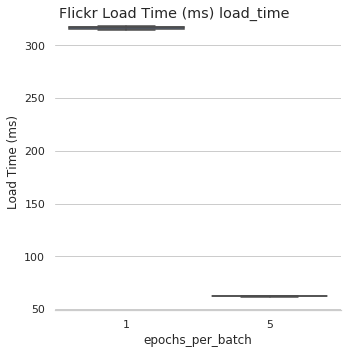

In [13]:
for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    for trainer_id in trainer_list:
        step51_run_investigation_summarize_whole(data_name, img_path,
                                         tune_param_name, tune_val_label, tune_val,
                                            trainer_list, model_epoch_list)
    
for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    for trainer_id in trainer_list:
        step50_run_tune_summarize_whole(data_name, img_path, 
                                    tune_param_name, tune_val_label_list, tune_val_list,
                                    trainer_list)